# Split Area Of Interest into tiles

The area of interest (AOI) at a country level is too large and needs to be tiled into smaller
pieces in order to be able to fit the one-year-long time series into memory.
Each piece is called an `EOPatch` in the `eo-learn` package. In order to create an
`EOPatch` we simply need the bounding box in a given coordinate reference system. We'll
use `BBOXSplitter` from [`sentinelhub`](https://github.com/sentinel-hub/sentinelhub-py) python package.

Each BBOX will later on be used do define an EOPatch.

---

This notebook performs the following actions:

1. Take buffered country
    * the defintion of Slovenia was taken from [here](http://www.naturalearthdata.com/downloads/10m-cultural-vectors/) and buffered a little bit
2. Convert it to selected CRS
    * taken to be the CRS of central UTM tile (UTM_33N)
3. Tile it into non-overlaping BBOXes
    * use `BBoxSplitter` from `sentinelhub` package
    * tile the buffered Slovenia into non-overlapping rectangular regions
    * each rectangular region defines a BBOX
4. Visualise the splitting
5. Store the BBOXes to disk
    * pickled list
    * geopandas dataframe

In [1]:
!pip install sentinelhub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.0/245.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.0 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=37fa5d5fa2af475199543dd7eabc0f5e3a738f30d07a9d771fa88c89532ecaf6
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os

import matplotlib.pyplot as plt

from sentinelhub import CRS, BBoxSplitter

In [4]:
from pathlib import Path

In [5]:
import geopandas as gpd
import pandas as pd

In [6]:
# Folder where data for running the notebook is stored
DATA_FOLDER = os.path.join(".",  "example_data")
# Locations for save the splitter to pickle file for later use
TILE_FOLDER = os.path.join(".", "tile-def")
# Locations for save the figs
FIGS_FOLDER = os.path.join(".", "figs")
for folder in (DATA_FOLDER, TILE_FOLDER, FIGS_FOLDER):
    os.makedirs(folder, exist_ok=True)

In [7]:
# Load input files in example_data
from google.colab import files
uploaded = files.upload()

Saving Imbabura-AOI.geojson to Imbabura-AOI.geojson


#### Selected CRS

In [8]:
country_crs = CRS.UTM_17N

## Load AOI

In this example it is buffered outline of Slovenia.

In [9]:
# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, "Imbabura-AOI.geojson"))

<Axes: >

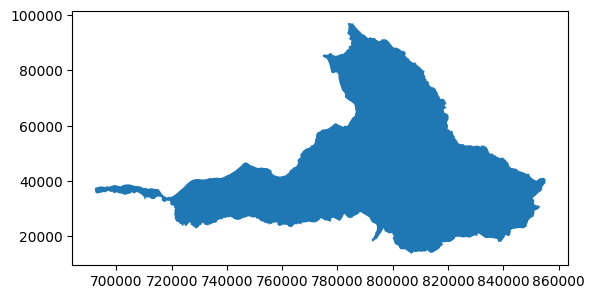

In [10]:
country.plot()

In [11]:
country.crs

<Projected CRS: EPSG:32617>
Name: WGS 84 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°W and 78°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Ecuador - north of equator. Canada - Nunavut; Ontario; Quebec. Cayman Islands. Colombia. Costa Rica. Cuba. Jamaica. Nicaragua. Panama. United States (USA).
- bounds: (-84.0, 0.0, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Reproject to selected CRS if needed:

In [12]:
if country.crs != country_crs:
    country = country.to_crs(crs=country_crs.pyproj_crs())

<Axes: >

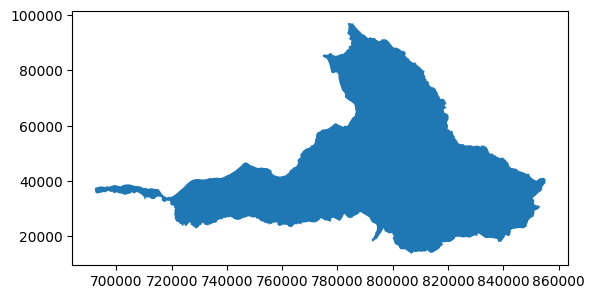

In [13]:
country.plot()

In [14]:
country.crs

<Projected CRS: EPSG:32617>
Name: WGS 84 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°W and 78°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Ecuador - north of equator. Canada - Nunavut; Ontario; Quebec. Cayman Islands. Colombia. Costa Rica. Cuba. Jamaica. Nicaragua. Panama. United States (USA).
- bounds: (-84.0, 0.0, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Get the polygon of AOI

In [15]:
country_shape = country.geometry.tolist()[-1]

### Estimate the size of Area Of Interest imbabura

In [16]:
country_shape.bounds

(692200.4182823192, 13669.0, 855393.7499999998, 97194.0)

In [17]:
print(
    "Dimension of the area is {0:.0f} x {1:.0f} m2".format(
        country_shape.bounds[2] - country_shape.bounds[0], country_shape.bounds[3] - country_shape.bounds[1]
    )
)

Dimension of the area is 163193 x 83525 m2


In [18]:
width_pix = int((country_shape.bounds[2] - country_shape.bounds[0]) / 10)
height_pix = int((country_shape.bounds[3] - country_shape.bounds[1]) / 10)

In [19]:
print("Dimension of the area is {} x {} pixels".format(width_pix, height_pix))

Dimension of the area is 16319 x 8352 pixels


# Perform tiling = get list of BBOXes

The AOI will be tiled in 25 (columns) x 17 (rows). The number of columns and tiles is selected in a way so that each EOPatch will have around 1000 x 1000 pixels at 10 meter resolution.

In [20]:
bbox_splitter = BBoxSplitter([country_shape], country_crs, (25, 17))

In [21]:
print("Area bounding box: {}\n".format(bbox_splitter.get_area_bbox().__repr__()))

Area bounding box: BBox(((692200.4182823192, 13669.0), (855393.7499999998, 97194.0)), crs=CRS('32617'))



In [22]:
bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

print(
    "Each bounding box also has some info how it was created. Example:\n\nbbox: {}\ninfo: {}\n".format(
        bbox_list[0].__repr__(), info_list[0]
    )
)

Each bounding box also has some info how it was created. Example:

bbox: BBox(((692200.4182823192, 33321.94117647059), (698728.1515510264, 38235.17647058824)), crs=CRS('32617'))
info: {'parent_bbox': BBox(((692200.4182823192, 13669.0), (855393.7499999998, 97194.0)), crs=CRS('32617')), 'index_x': 0, 'index_y': 4}



The total number of tiles is:

In [23]:
len(bbox_splitter.bbox_list)

195

### Save the splitter to pickle file for later use

In [24]:
import pickle

In [26]:
if not os.path.isdir("./tile-def"):
    os.makedirs("./tile-def")

with open("./tile-def/Imbabura_buffered_bbox_32617_17x25.pickle", "wb") as fp:
    pickle.dump(bbox_splitter, fp)

## Visualise the tiling

### Convert to geopandas dataframe

In [27]:
from shapely.geometry import Polygon

In [28]:
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
idxs_x = [info["index_x"] for info in bbox_splitter.info_list]
idxs_y = [info["index_y"] for info in bbox_splitter.info_list]

df = pd.DataFrame({"index_x": idxs_x, "index_y": idxs_y})
common_crs = bbox_splitter.bbox_list[0].crs
gdf = gpd.GeoDataFrame(df, crs=common_crs.pyproj_crs(), geometry=geometry)

In [29]:
gdf.head()

,index_x,index_y,geometry
0,0,4,"POLYGON ((692200.418 33321.941, 692200.418 382..."
1,0,5,"POLYGON ((692200.418 38235.176, 692200.418 431..."
2,1,4,"POLYGON ((698728.152 33321.941, 698728.152 382..."
3,1,5,"POLYGON ((698728.152 38235.176, 698728.152 431..."
4,2,3,"POLYGON ((705255.885 28408.706, 705255.885 333..."


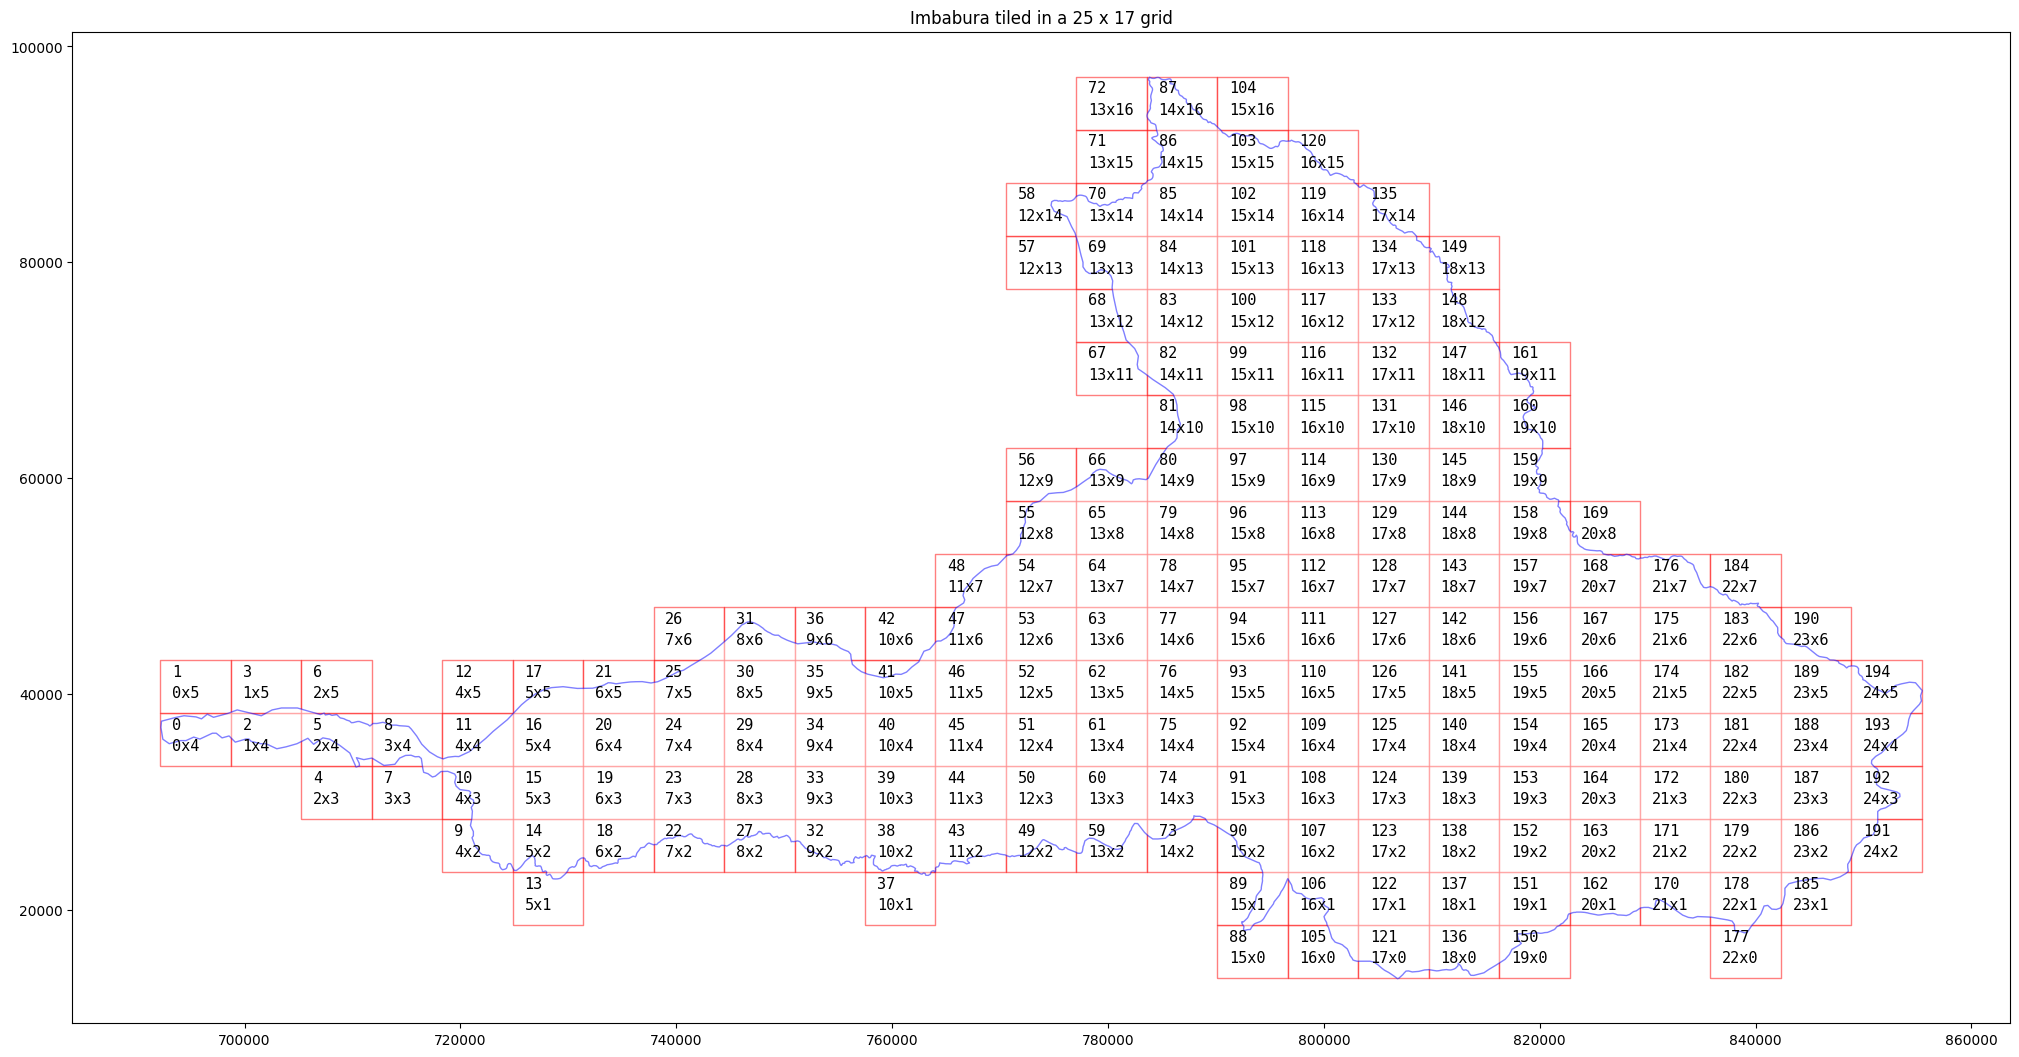

In [30]:
fontdict = {"family": "monospace", "weight": "normal", "size": 11}
# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 5
# figure
fig, ax = plt.subplots(figsize=(25, 17))
gdf.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)
country.plot(ax=ax, facecolor="w", edgecolor="b", alpha=0.5)
ax.set_title("Imbabura tiled in a 25 x 17 grid")
# add annotiation text
for idx in gdf.index:
    eop_name = "{0}x{1}".format(gdf.index_x[idx], gdf.index_y[idx])
    (centroid,) = list(gdf.geometry[idx].centroid.coords)
    ax.text(centroid[0] - xoff, centroid[1] + yoff, "{}".format(idx), fontdict=fontdict)
    ax.text(centroid[0] - xoff, centroid[1] - yoff, eop_name, fontdict=fontdict)

if not os.path.isdir("./figs"):
    os.makedirs("./figs")
fig.savefig("./figs/Imbabura_aoi_to_tiles.png", bbox_inches="tight")

In [31]:
gdf.to_file("./tile-def/Imbabura_buffered_bbox_32617_17x25.gpkg", driver="GPKG")